In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings

In [40]:
warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid')

In [41]:
# Load the data
df = pd.read_csv("C:/Users/ammur/Downloads/train.csv")
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

In [48]:
# Prepare function to fill missing months for any group
def preprocess_monthly_sales(data, date_col='Order Date', target_col='Sales'):
    monthly_sales = data.groupby(pd.Grouper(key=date_col, freq='M'))[target_col].sum().reset_index()
    monthly_sales.columns = ['ds', 'y']
    full_months = pd.date_range(start=monthly_sales['ds'].min(), end=monthly_sales['ds'].max(), freq='M')
    monthly_sales = monthly_sales.set_index('ds').reindex(full_months, fill_value=0).reset_index()
    monthly_sales.columns = ['ds', 'y']
    return monthly_sales


In [49]:
# 1. Prophet Forecast by Group
def forecast_by_group(df, group_col, forecast_periods=12):
    results = []
    groups = df[group_col].unique()
    for group in groups:
        subset = df[df[group_col] == group]
        monthly_sales = preprocess_monthly_sales(subset)
        if monthly_sales['y'].dropna().shape[0] < 2:
            continue
        model = Prophet()
        model.fit(monthly_sales)
        future = model.make_future_dataframe(periods=forecast_periods, freq='M')
        forecast = model.predict(future)
        try:
            rmse = np.sqrt(mean_squared_error(
                monthly_sales.tail(forecast_periods)['y'],
                forecast.set_index('ds').loc[monthly_sales.tail(forecast_periods)['ds']]['yhat'].values
            ))
            results.append((group, rmse))
        except:
            continue
    return results

In [50]:
# 2. Linear Regression Forecast by Group
def linear_regression_forecast_by_group(df, group_col, forecast_periods=12):
    results = []
    groups = df[group_col].unique()
    for group in groups:
        subset = df[df[group_col] == group]
        monthly_sales = preprocess_monthly_sales(subset)
        if monthly_sales['y'].dropna().shape[0] < 2:
            continue
        monthly_sales['t'] = np.arange(len(monthly_sales))
        X = monthly_sales[['t']]
        y = monthly_sales['y']
        model = LinearRegression()
        model.fit(X, y)
        future_t = np.arange(len(monthly_sales), len(monthly_sales) + forecast_periods).reshape(-1, 1)
        y_pred = model.predict(future_t)
        y_true = np.zeros(forecast_periods)  # Placeholder for real future values
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        results.append((group, rmse))
    return results

In [51]:
# 3. Visualizations based on SQL insights
def visualize_sql_insights(df):
    subcat_sales = df.groupby('Sub-Category')['Sales'].sum().sort_values(ascending=False).head(10)
    subcat_sales.plot(kind='bar', figsize=(10, 5), title="Top 10 Sub-Categories by Sales")
    plt.xlabel("Sub-Category")
    plt.ylabel("Total Sales")
    plt.tight_layout()
    plt.show()

    monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum()
    monthly_sales.plot(figsize=(12, 5), title="Monthly Sales Trend")
    plt.xlabel("Month")
    plt.ylabel("Sales")
    plt.tight_layout()
    plt.show()

In [52]:
# Run Prophet forecasts
subcat_results = forecast_by_group(df, 'Sub-Category')
state_results = forecast_by_group(df, 'State')
category_results = forecast_by_group(df, 'Category')
region_results = forecast_by_group(df, 'Region')

14:56:48 - cmdstanpy - INFO - Chain [1] start processing
14:56:48 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:51 - cmdstanpy - INFO - Chain [1] done processing
14:56:51 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing
14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing
14:56:53 - cmdstanpy - INFO - Chain [1] start processing
14:56:54 - cmdstanpy - INFO - Chain [1] done processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:56 - cmdstanpy - INFO - Chain [1] start processing
14:56:56 - cmdstanpy - INFO - Chain [1] done processing
14:56:57 - cmdstanpy - INFO - Chain [1] start processing
14:56:58 - cmdstanpy - INFO - Chain [1]

In [53]:
# Run Linear Regression forecasts
subcat_linreg_results = linear_regression_forecast_by_group(df, 'Sub-Category')
state_linreg_results = linear_regression_forecast_by_group(df, 'State')
category_linreg_results = linear_regression_forecast_by_group(df, 'Category')
region_linreg_results = linear_regression_forecast_by_group(df, 'Region')


In [54]:
# Show outputs
print("Top 5 Sub-Category Forecast RMSE (Prophet):", subcat_results[:5])
print("Top 5 State Forecast RMSE (Prophet):", state_results[:5])
print("Top 5 Category Forecast RMSE (Prophet):", category_results[:5])
print("Top 5 Region Forecast RMSE (Prophet):", region_results[:5])

Top 5 Sub-Category Forecast RMSE (Prophet): [('Bookcases', 1676.1369334892424), ('Chairs', 2209.2935770407075), ('Labels', 210.67437351760705), ('Tables', 2174.7450481431983), ('Storage', 1383.7022767537578)]
Top 5 State Forecast RMSE (Prophet): [('Kentucky', 1353.5138409605495), ('California', 2581.3175744729997), ('Florida', 3307.354468894349), ('North Carolina', 2519.794380173707), ('Washington', 3235.3573143167882)]
Top 5 Category Forecast RMSE (Prophet): [('Furniture', 3073.1884892143735), ('Office Supplies', 4798.849683435525), ('Technology', 5037.3555652268)]
Top 5 Region Forecast RMSE (Prophet): [('South', 5140.7853970873175), ('West', 3162.200127004654), ('Central', 4276.667775225486), ('East', 5915.98126158748)]


In [55]:
print("Top 5 Sub-Category Forecast RMSE (Linear Regression):", subcat_linreg_results[:5])
print("Top 5 State Forecast RMSE (Linear Regression):", state_linreg_results[:5])
print("Top 5 Category Forecast RMSE (Linear Regression):", category_linreg_results[:5])
print("Top 5 Region Forecast RMSE (Linear Regression):", region_linreg_results[:5])

Top 5 Sub-Category Forecast RMSE (Linear Regression): [('Bookcases', 3313.572820344353), ('Chairs', 9570.019439750613), ('Labels', 371.614620135132), ('Tables', 6725.264394589103), ('Storage', 6965.513884422177)]
Top 5 State Forecast RMSE (Linear Regression): [('Kentucky', 1298.656152663232), ('California', 15091.79043562488), ('Florida', 1214.6547362345284), ('North Carolina', 2337.9361101336185), ('Washington', 5336.012328021545)]
Top 5 Category Forecast RMSE (Linear Regression): [('Furniture', 22864.20404122802), ('Office Supplies', 23885.226297755245), ('Technology', 27079.17915252136)]
Top 5 Region Forecast RMSE (Linear Regression): [('South', 10255.852263807623), ('West', 24706.617123410237), ('Central', 15453.554095579397), ('East', 23414.565412330445)]


In [56]:
# Combine Prophet and Linear Regression RMSE into a DataFrame
def create_rmse_df(prophet_result, linreg_result, label):
    df_prophet = pd.DataFrame(prophet_result, columns=[label, 'Prophet_RMSE'])
    df_linreg = pd.DataFrame(linreg_result, columns=[label, 'Linear_RMSE'])
    merged = pd.merge(df_prophet, df_linreg, on=label, how='inner')
    return merged.sort_values(by='Prophet_RMSE').reset_index(drop=True)

# Create and display RMSE tables
rmse_subcat_df = create_rmse_df(subcat_results, subcat_linreg_results, 'Sub-Category')
rmse_state_df = create_rmse_df(state_results, state_linreg_results, 'State')
rmse_category_df = create_rmse_df(category_results, category_linreg_results, 'Category')
rmse_region_df = create_rmse_df(region_results, region_linreg_results, 'Region')

print("Sub-Category RMSE Comparison:\n", rmse_subcat_df.head())
print("State RMSE Comparison:\n", rmse_state_df.head())
print("Category RMSE Comparison:\n", rmse_category_df.head())
print("Region RMSE Comparison:\n", rmse_region_df.head())


Sub-Category RMSE Comparison:
   Sub-Category  Prophet_RMSE  Linear_RMSE
0    Fasteners     28.147446    98.044140
1    Envelopes    121.760360   375.349225
2          Art    189.658354   826.843240
3       Labels    210.674374   371.614620
4        Paper    489.410480  2820.577115
State RMSE Comparison:
                   State  Prophet_RMSE  Linear_RMSE
0                 Maine    106.471776    34.193376
1        South Carolina    106.799778    93.047153
2  District of Columbia    122.506068   396.090254
3                Kansas    132.839710    13.992561
4            New Mexico    169.557120   227.047977
Category RMSE Comparison:
           Category  Prophet_RMSE   Linear_RMSE
0        Furniture   3073.188489  22864.204041
1  Office Supplies   4798.849683  23885.226298
2       Technology   5037.355565  27079.179153
Region RMSE Comparison:
     Region  Prophet_RMSE   Linear_RMSE
0     West   3162.200127  24706.617123
1  Central   4276.667775  15453.554096
2    South   5140.785397  1025

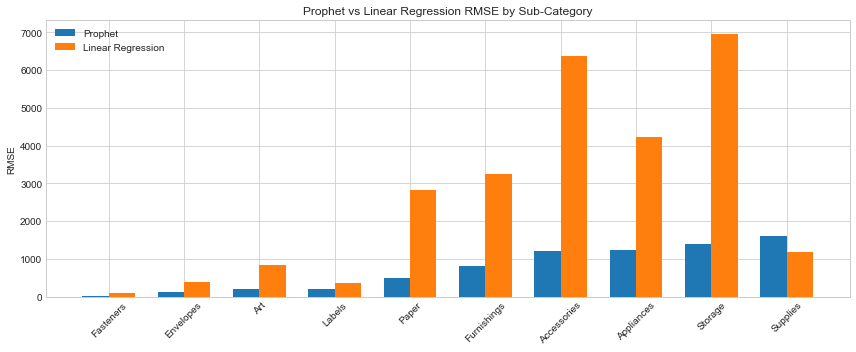

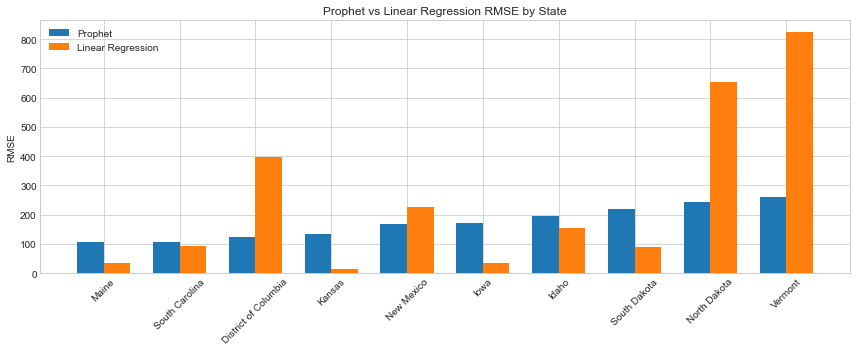

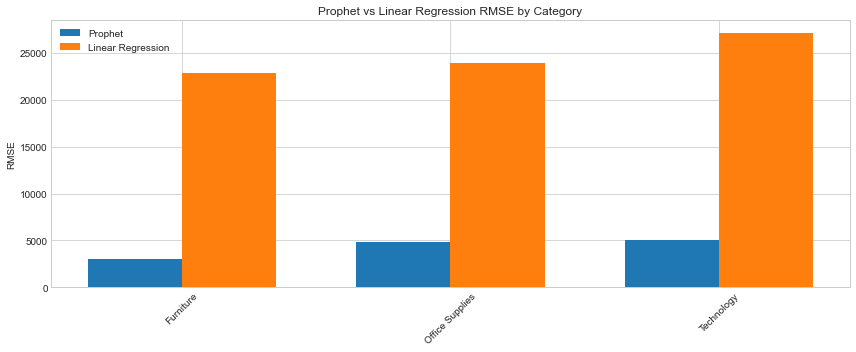

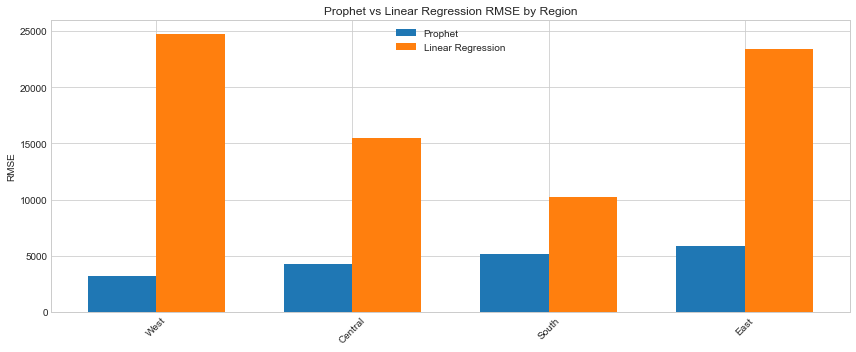

In [57]:
def plot_rmse_comparison(df, group_col):
    df = df.sort_values(by='Prophet_RMSE').head(10)
    x = np.arange(len(df[group_col]))
    width = 0.35

    plt.figure(figsize=(12, 5))
    plt.bar(x - width/2, df['Prophet_RMSE'], width, label='Prophet')
    plt.bar(x + width/2, df['Linear_RMSE'], width, label='Linear Regression')
    plt.xticks(x, df[group_col], rotation=45)
    plt.ylabel('RMSE')
    plt.title(f'Prophet vs Linear Regression RMSE by {group_col}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the graph functions
plot_rmse_comparison(rmse_subcat_df, 'Sub-Category')
plot_rmse_comparison(rmse_state_df, 'State')
plot_rmse_comparison(rmse_category_df, 'Category')
plot_rmse_comparison(rmse_region_df, 'Region')


In [58]:
def plot_prophet_forecast(df, group_col, group_name, periods=12):
    subset = df[df[group_col] == group_name]
    monthly_sales = preprocess_monthly_sales(subset)
    
    model = Prophet()
    model.fit(monthly_sales)
    future = model.make_future_dataframe(periods=periods, freq='M')
    forecast = model.predict(future)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_sales['ds'], monthly_sales['y'], label='Actual Sales', color='blue')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Sales (Prophet)', color='orange')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color='orange')
    plt.title(f'Prophet Forecast vs Actual Sales - {group_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()


15:05:43 - cmdstanpy - INFO - Chain [1] start processing
15:05:43 - cmdstanpy - INFO - Chain [1] done processing


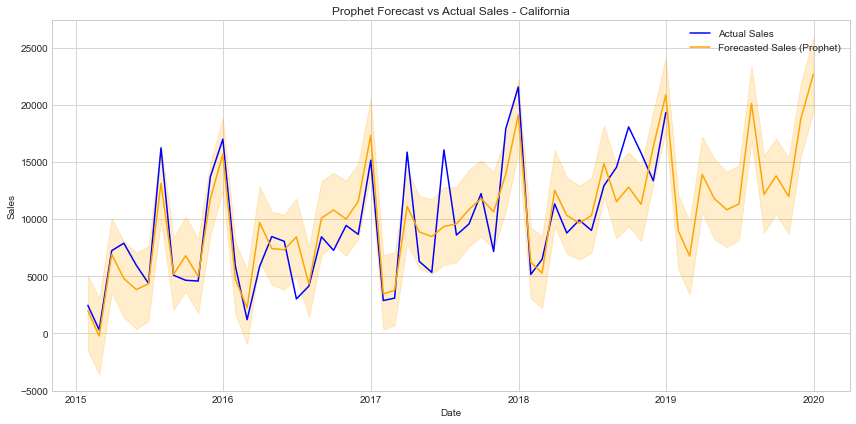

15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing


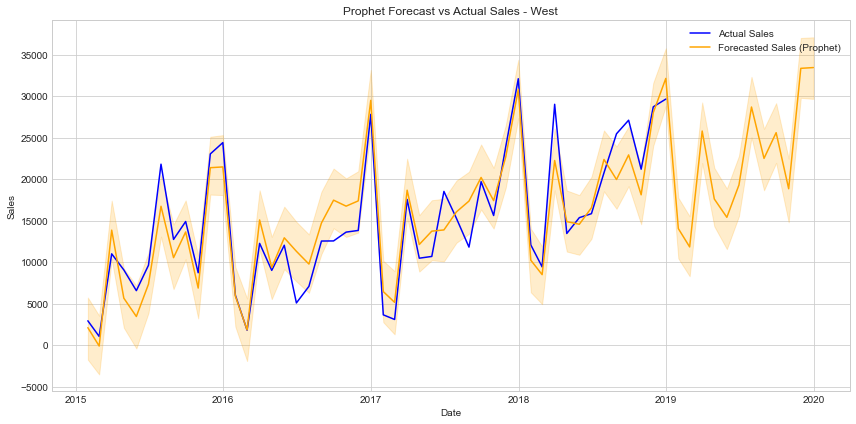

In [60]:
plot_prophet_forecast(df, 'State', 'California')
plot_prophet_forecast(df, 'Region', 'West')


In [61]:
def plot_multiple_forecasts(df, group_col, top_n=3, periods=12):
    top_groups = df[group_col].value_counts().head(top_n).index.tolist()
    for group in top_groups:
        subset = df[df[group_col] == group]
        monthly_sales = preprocess_monthly_sales(subset)

        if monthly_sales['y'].dropna().shape[0] < 2:
            continue

        model = Prophet()
        model.fit(monthly_sales)
        future = model.make_future_dataframe(periods=periods, freq='M')
        forecast = model.predict(future)

        plt.figure(figsize=(12, 5))
        plt.plot(monthly_sales['ds'], monthly_sales['y'], label='Actual Sales', color='blue')
        plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Sales', color='orange')
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color='orange')
        plt.title(f"Forecast vs Actual Sales - {group_col}: {group}")
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.legend()
        plt.tight_layout()
        plt.show()


15:06:42 - cmdstanpy - INFO - Chain [1] start processing
15:06:43 - cmdstanpy - INFO - Chain [1] done processing


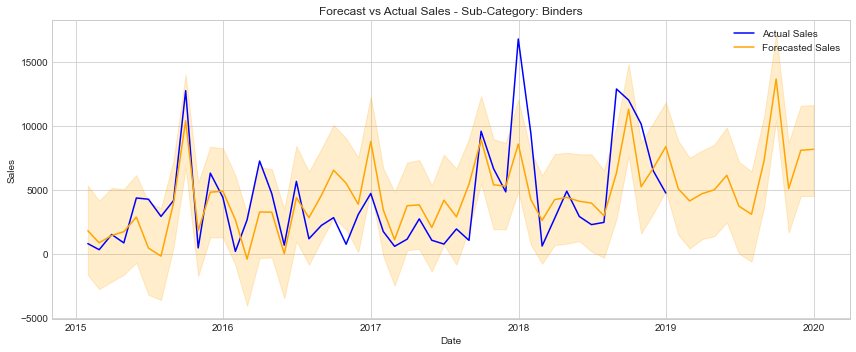

15:06:44 - cmdstanpy - INFO - Chain [1] start processing
15:06:44 - cmdstanpy - INFO - Chain [1] done processing


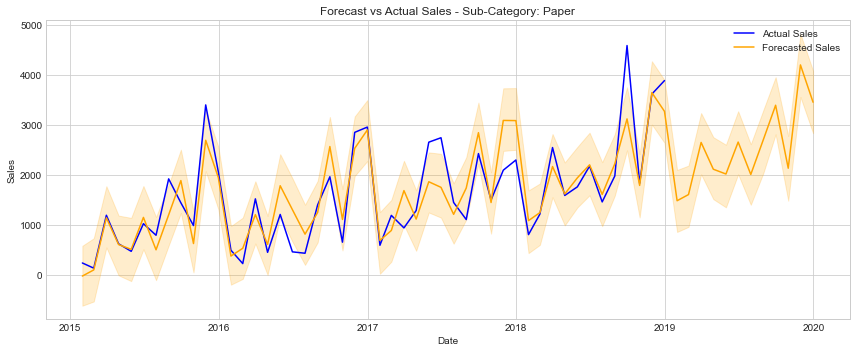

15:06:46 - cmdstanpy - INFO - Chain [1] start processing
15:06:46 - cmdstanpy - INFO - Chain [1] done processing


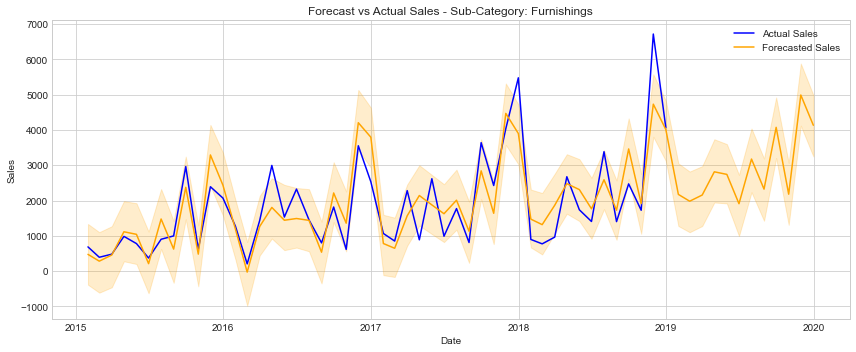

15:06:47 - cmdstanpy - INFO - Chain [1] start processing
15:06:48 - cmdstanpy - INFO - Chain [1] done processing


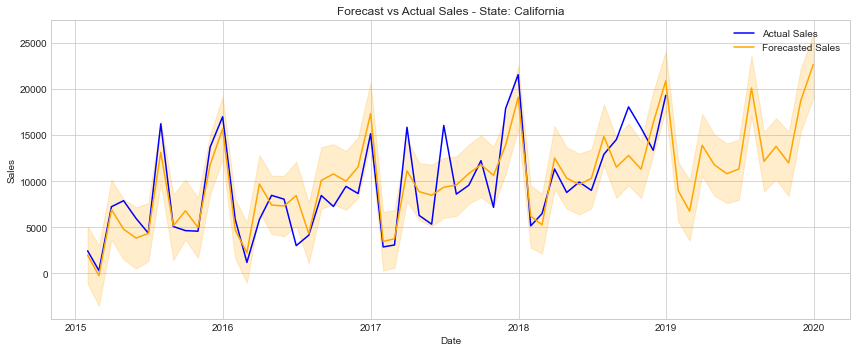

15:06:49 - cmdstanpy - INFO - Chain [1] start processing
15:06:50 - cmdstanpy - INFO - Chain [1] done processing


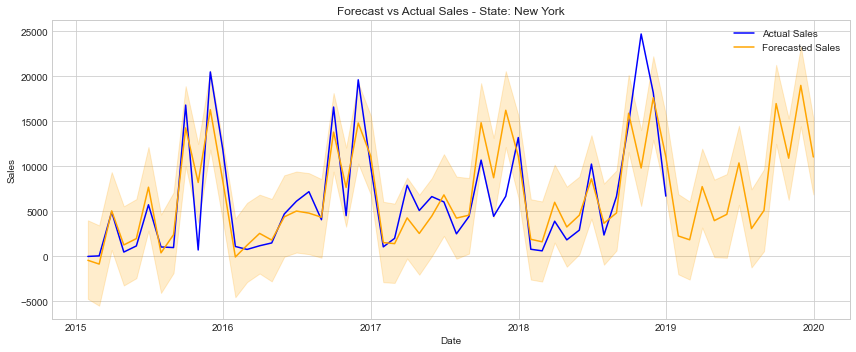

15:06:52 - cmdstanpy - INFO - Chain [1] start processing
15:06:53 - cmdstanpy - INFO - Chain [1] done processing


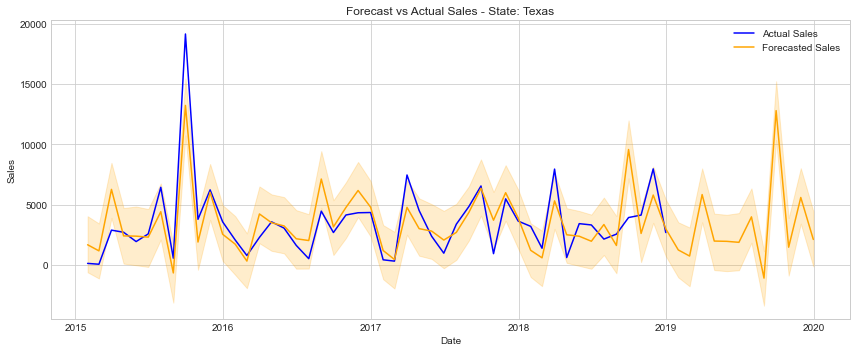

15:06:54 - cmdstanpy - INFO - Chain [1] start processing
15:06:55 - cmdstanpy - INFO - Chain [1] done processing


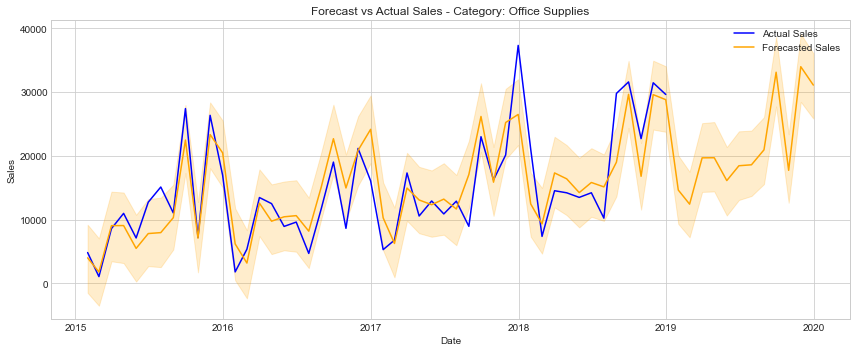

15:06:56 - cmdstanpy - INFO - Chain [1] start processing
15:06:57 - cmdstanpy - INFO - Chain [1] done processing


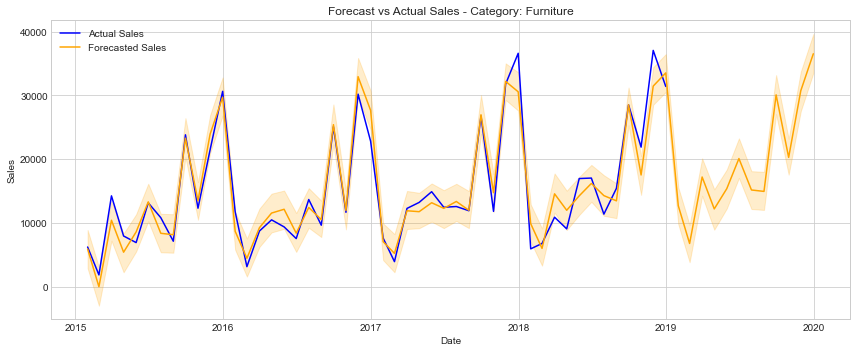

15:06:58 - cmdstanpy - INFO - Chain [1] start processing
15:06:58 - cmdstanpy - INFO - Chain [1] done processing


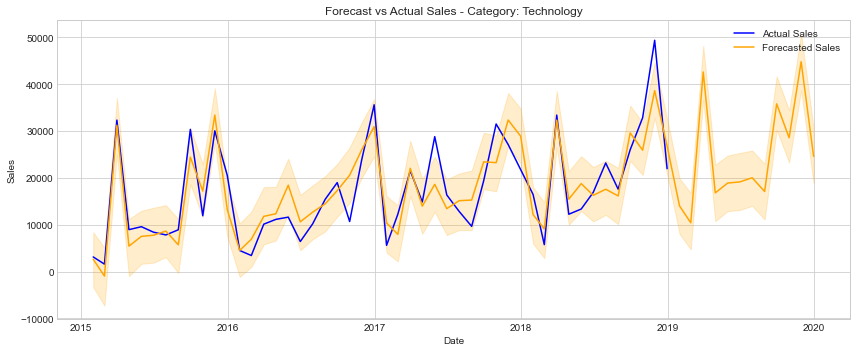

15:06:59 - cmdstanpy - INFO - Chain [1] start processing
15:07:00 - cmdstanpy - INFO - Chain [1] done processing


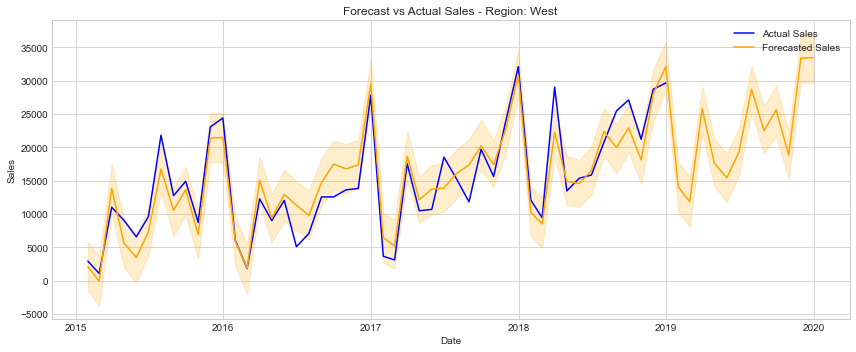

15:07:02 - cmdstanpy - INFO - Chain [1] start processing
15:07:02 - cmdstanpy - INFO - Chain [1] done processing


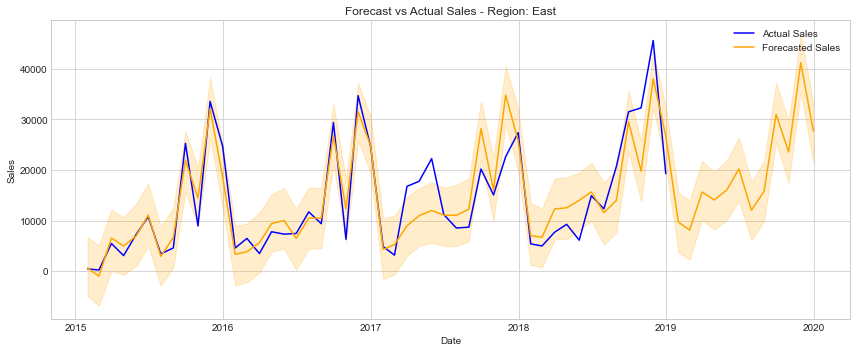

15:07:03 - cmdstanpy - INFO - Chain [1] start processing
15:07:04 - cmdstanpy - INFO - Chain [1] done processing


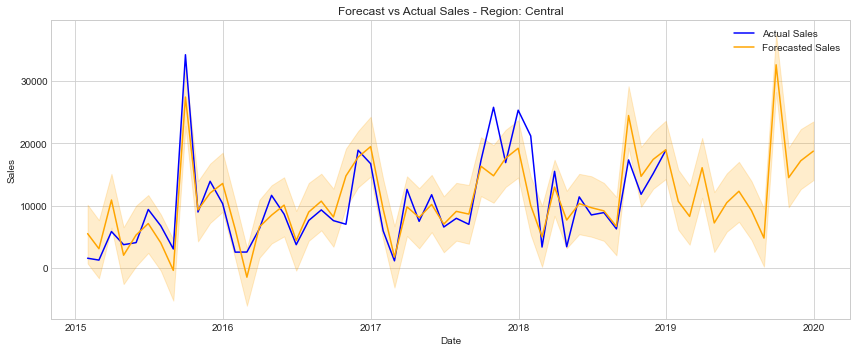

15:07:05 - cmdstanpy - INFO - Chain [1] start processing
15:07:06 - cmdstanpy - INFO - Chain [1] done processing


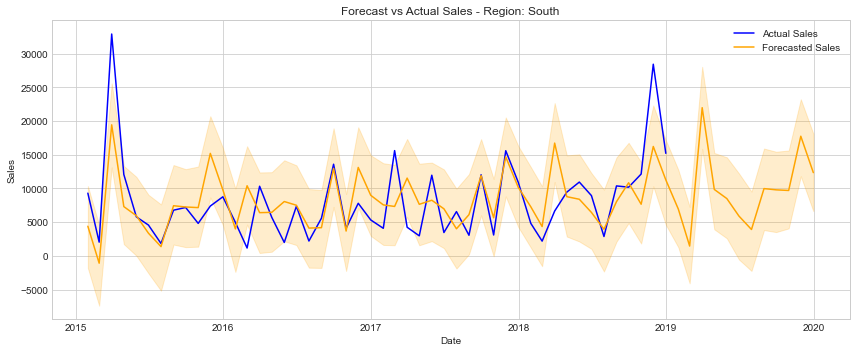

In [62]:
# Plot for top 3 Sub-Categories
plot_multiple_forecasts(df, 'Sub-Category')

# Plot for top 3 States
plot_multiple_forecasts(df, 'State')

# Plot for all 3 Categories (Furniture, Office Supplies, Technology)
plot_multiple_forecasts(df, 'Category', top_n=3)

# Plot for all 4 Regions
plot_multiple_forecasts(df, 'Region', top_n=4)


In [63]:
def forecast_plot_by_category(df, periods=12):
    categories = df['Category'].unique()
    
    for category in categories:
        subset = df[df['Category'] == category]
        monthly_sales = preprocess_monthly_sales(subset)

        if monthly_sales['y'].dropna().shape[0] < 2:
            continue
        
        model = Prophet()
        model.fit(monthly_sales)
        future = model.make_future_dataframe(periods=periods, freq='M')
        forecast = model.predict(future)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(monthly_sales['ds'], monthly_sales['y'], label='Actual Sales', color='blue')
        plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Sales (Prophet)', color='orange')
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color='orange')
        plt.title(f'Prophet Forecast vs Actual Sales - Category: {category}')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.tight_layout()
        plt.show()


15:08:08 - cmdstanpy - INFO - Chain [1] start processing
15:08:09 - cmdstanpy - INFO - Chain [1] done processing


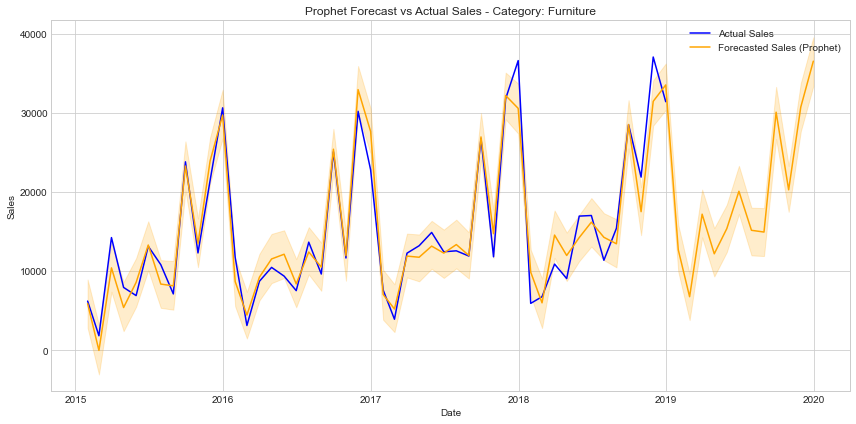

15:08:10 - cmdstanpy - INFO - Chain [1] start processing
15:08:10 - cmdstanpy - INFO - Chain [1] done processing


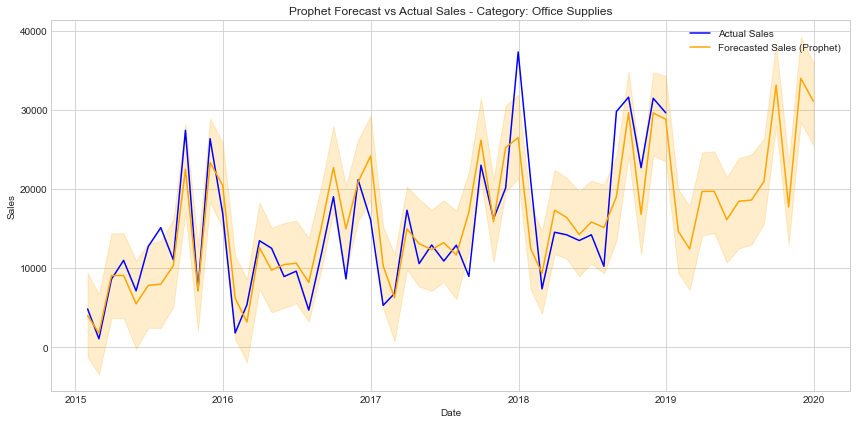

15:08:12 - cmdstanpy - INFO - Chain [1] start processing
15:08:12 - cmdstanpy - INFO - Chain [1] done processing


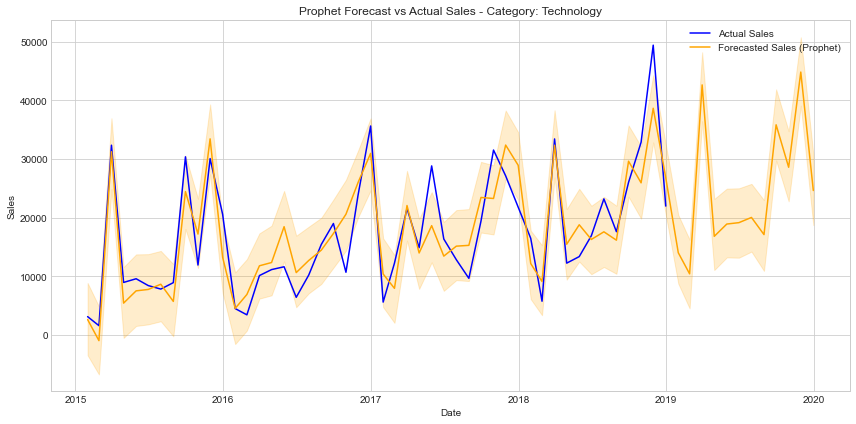

In [64]:
forecast_plot_by_category(df)


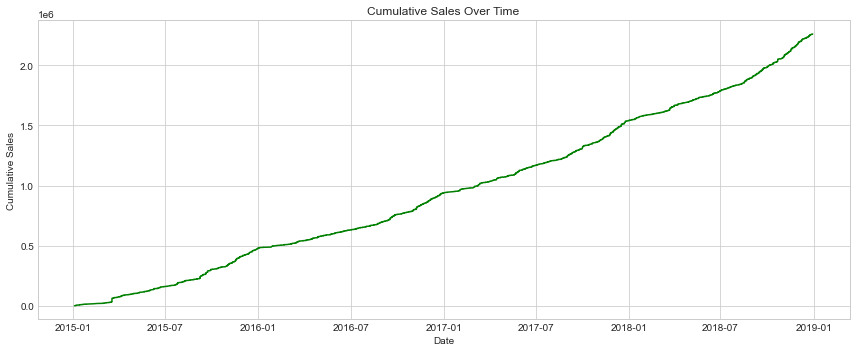

In [66]:
def plot_cumulative_sales(df):
    df_sorted = df.sort_values('Order Date')
    df_sorted['Cumulative Sales'] = df_sorted['Sales'].cumsum()

    plt.figure(figsize=(12, 5))
    plt.plot(df_sorted['Order Date'], df_sorted['Cumulative Sales'], color='green')
    plt.title("Cumulative Sales Over Time")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Sales")
    plt.tight_layout()
    plt.show()

plot_cumulative_sales(df)


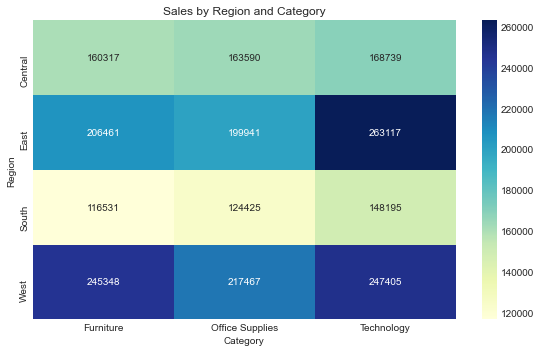

In [67]:
def plot_sales_heatmap(df):
    pivot = df.pivot_table(index='Region', columns='Category', values='Sales', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("Sales by Region and Category")
    plt.tight_layout()
    plt.show()

plot_sales_heatmap(df)


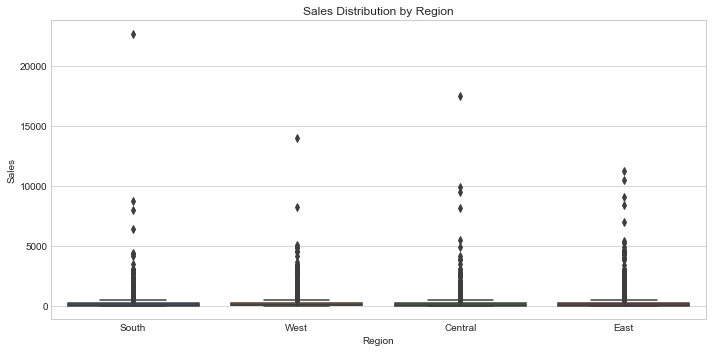

In [68]:
def plot_sales_distribution(df):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Region', y='Sales', data=df)
    plt.title("Sales Distribution by Region")
    plt.tight_layout()
    plt.show()

plot_sales_distribution(df)


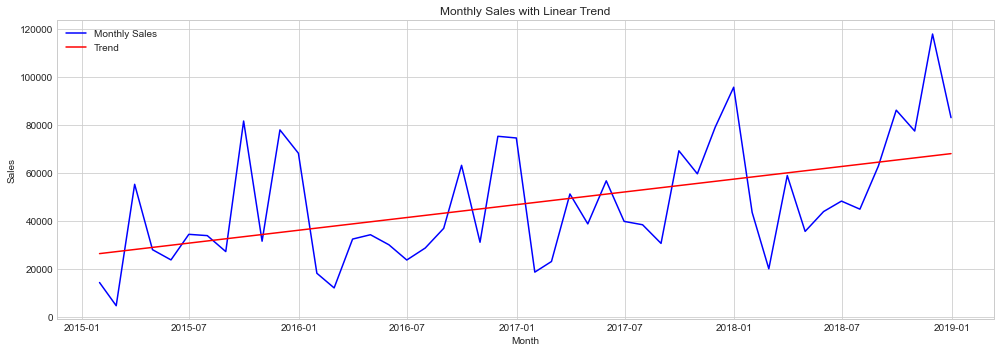

In [71]:
def plot_monthly_sales_trend_fixed(df):
    monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()

    # Convert 'Order Date' to ordinal for regression
    monthly_sales['date_ordinal'] = monthly_sales['Order Date'].map(pd.Timestamp.toordinal)

    # Fit linear regression manually
    model = LinearRegression()
    model.fit(monthly_sales[['date_ordinal']], monthly_sales['Sales'])
    monthly_sales['trend'] = model.predict(monthly_sales[['date_ordinal']])

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(monthly_sales['Order Date'], monthly_sales['Sales'], label='Monthly Sales', color='blue')
    plt.plot(monthly_sales['Order Date'], monthly_sales['trend'], label='Trend', color='red')
    plt.title("Monthly Sales with Linear Trend")
    plt.xlabel("Month")
    plt.ylabel("Sales")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_monthly_sales_trend_fixed(df)



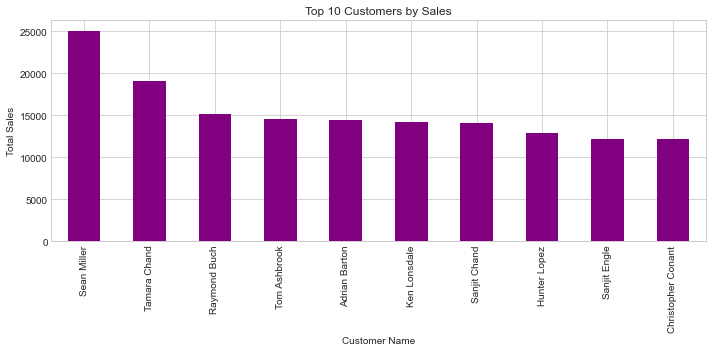

In [70]:
def plot_top_customers(df, top_n=10):
    top_customers = df.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(10, 5))
    top_customers.plot(kind='bar', color='purple')
    plt.title(f"Top {top_n} Customers by Sales")
    plt.ylabel("Total Sales")
    plt.xlabel("Customer Name")
    plt.tight_layout()
    plt.show()

plot_top_customers(df)
